# Ann Arbor Network


Reproduce the control experiment to see if bayesian optimization can match the performance of reinforcemnet learning controller. We control ponds 1,2,3,4 with the objective of maintaining the flows below a threshold with out flooding (similar objective was achived in the RL paper).

In [1]:
# Import the necessary library 
## Plotting Libraries 
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import seaborn as sns
import scipy.signal as spy
import scipy

## Pyswmm engine with ICC 
from pyswmm_lite import Env

## Bayesian Optimization
import numpy as np
from GPyOpt.methods import BayesianOptimization
import tslearn.metrics as ts
import copy

In [2]:
NODES_LIS = {'93-49743' : 'OR39',
             '93-49868' : 'OR34',
             '93-49919' : 'OR44',
             '93-49921' : 'OR45',
             '93-50074' : 'OR38',
             '93-50076' : 'OR46',
             '93-50077' : 'OR48',
             '93-50081' : 'OR47',
             '93-50225' : 'OR36',
             '93-90357' : 'OR43',
             '93-90358' : 'OR35'}


def run_swmm(valve_set1, valve_set2, valve_set3, valve_set4):
    env = Env("./networks/aa_0360min_025yr.inp")

    data = {}
    data["f1"] = []
    data["f2"] = []
    data["f3"] = []
    data["f4"] = []
    data["overflow1"]  = []
    data["overflow2"]  = []
    data["overflow3"]  = []
    data["overflow4"]  = []
    done = False
    for i in range(0, 35000):
        # set the gate_position 
        env.set_gate(NODES_LIS["93-50077"], valve_set1)
        env.set_gate(NODES_LIS["93-50076"], valve_set2)
        env.set_gate(NODES_LIS["93-50081"], valve_set3)
        env.set_gate(NODES_LIS["93-49921"], valve_set4)
        
        # record_data
        data["f1"].append(env.flow(NODES_LIS["93-50077"]))
        data["f2"].append(env.flow(NODES_LIS["93-50076"]))
        data["f4"].append(env.flow(NODES_LIS["93-49921"]))
        data["f3"].append(env.flow(NODES_LIS["93-50081"]))
        
        data["overflow1"].append(env.sim._model.getNodeResult("93-50077", 4))
        data["overflow2"].append(env.sim._model.getNodeResult("93-50076", 4))
        data["overflow4"].append(env.sim._model.getNodeResult("93-49921", 4))
        data["overflow3"].append(env.sim._model.getNodeResult("93-50081", 4))
        
        # step through simulation
        done = env.step()
        
    overflows = {}
    overflows["o1"] = sum(data["overflow1"])
    overflows["o2"] = sum(data["overflow2"])
    overflows["o3"] = sum(data["overflow3"])
    overflows["o4"] = sum(data["overflow4"])
    
    env.sim._model.swmm_end()
    env.sim._model.swmm_close()
    return data, overflows

# Plot the uncontrolled reponse 
un_data, un_overflow = run_swmm(1.0, 1.0, 1.0, 1.0)

In [3]:
# Desired control objective
downstream_target1 = np.asarray(copy.deepcopy(un_data["f1"]))
downstream_target1[downstream_target1 > 4.5] = 4.5
downstream_target1d =  spy.decimate(downstream_target1, 50)

downstream_target2 = np.asarray(copy.deepcopy(un_data["f2"]))
downstream_target2[downstream_target2 > 4.0] = 4.0
downstream_target2d =  spy.decimate(downstream_target2, 50)


downstream_target3 = np.asarray(copy.deepcopy(un_data["f3"]))
downstream_target3[downstream_target3 > 4.0] = 4.0
downstream_target3d =  spy.decimate(downstream_target3, 50)

downstream_target4 = 0.6 * np.asarray(copy.deepcopy(un_data["f4"]))
downstream_target4d =  spy.decimate(downstream_target4, 50)

<IPython.core.display.Javascript object>


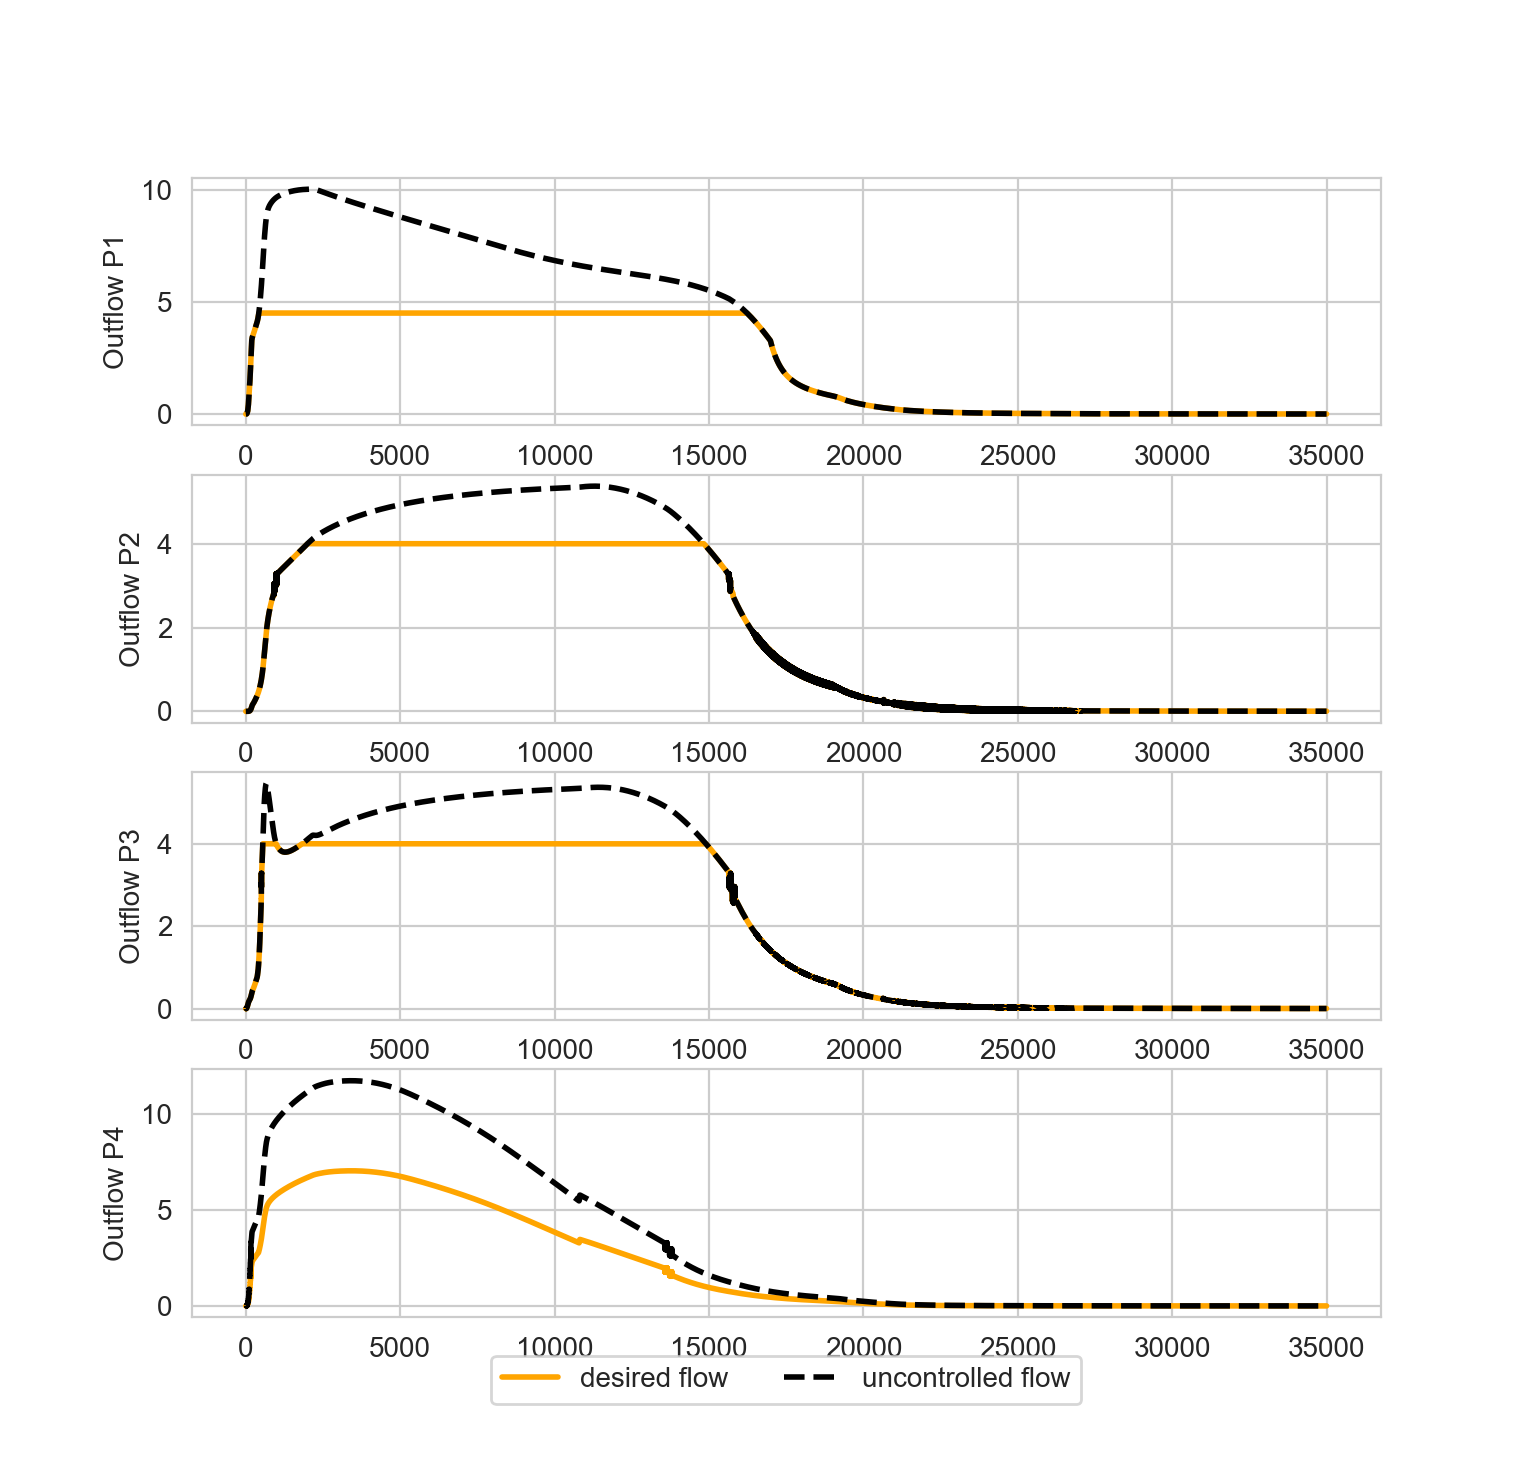

Text(0, 0.5, 'Outflow P4')

In [10]:
plt.subplot(4, 1, 1)
plt.plot(downstream_target1, "orange", label = "desired flow", linewidth=2.0)
plt.plot(un_data["f1"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P1")

plt.subplot(4, 1, 2)
plt.plot(downstream_target2, "orange", label = "desired flow", linewidth=2.0)
plt.plot(un_data["f2"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P2")

plt.subplot(4, 1, 3)
plt.plot(downstream_target3, "orange", label = "desired flow", linewidth=2.0)
plt.plot(un_data["f3"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P3")

plt.subplot(4, 1, 4)
plt.plot(downstream_target4, "orange", label = "desired flow", linewidth=2.0)
plt.plot(un_data["f4"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.ylabel("Outflow P4")

## Create a obj function based on the DTW for AA

In [4]:
def fc(x):
    data, overflow  = run_swmm(x[0][0], x[0][1], x[0][2], x[0][3])
    pred_flow1 = np.asarray(data["f1"])
    pred_flow2 = np.asarray(data["f2"])
    pred_flow3 = np.asarray(data["f3"])
    pred_flow4 = np.asarray(data["f4"])

    pred_flow1 =  spy.decimate(pred_flow1, 50)
    pred_flow2 =  spy.decimate(pred_flow2, 50)
    pred_flow3 =  spy.decimate(pred_flow3, 50)
    pred_flow4 =  spy.decimate(pred_flow4, 50)


    path, distance1 = ts.dtw_path(downstream_target1d,
            pred_flow1,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)

    path, distance2 = ts.dtw_path(downstream_target2d,
            pred_flow2,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)
    
    path, distance3 = ts.dtw_path(downstream_target3d,
            pred_flow3,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)
    
    path, distance4 = ts.dtw_path(downstream_target4d,
            pred_flow4,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)

    # sum of the outflows
    d = 0.0
    for i in overflow.keys():
        d += overflow[i]
    loss = distance1*10.0 + distance2 + distance3 + distance4*10.0  + (d)*10.0
    #print("Distance : {0}, Overflow : {1}".format(distance1 + distance2 + distance3 + distance4, d))
    #print("Valve ",x)
    return loss

In [5]:
# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_3', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_4', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 4)

myBopt.run_optimization(max_iter=150)

In [6]:
c_data, c_overflow = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], myBopt.x_opt[2], myBopt.x_opt[3])

Text(0, 0.5, 'Outflow P4')

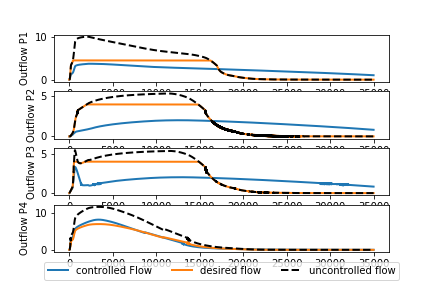

In [7]:
plt.subplot(4, 1, 1)
plt.plot(c_data["f1"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target1, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f1"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P1")

plt.subplot(4, 1, 2)
plt.plot(c_data["f2"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target2, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f2"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P2")

plt.subplot(4, 1, 3)
plt.plot(c_data["f3"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target3, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f3"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P3")

plt.subplot(4, 1, 4)
plt.plot(c_data["f4"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target4, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f4"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.ylabel("Outflow P4")

In [8]:
myBopt.x_opt

array([0.34511611, 0.15937712, 0.48244834, 0.65038868])

In [ ]:
Essentially 